In [1]:
!pip install pydicom
!pip install medmnist
!pip install pennylane

In [2]:
import os

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn.functional as F
from pydicom import Dataset

from tqdm import tqdm

from medmnist import BreastMNIST
from medmnist import INFO

import pennylane as qml

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"Using: {torch.cuda.get_device_name(0)}")
    print(f"CUDA: {torch.version.cuda}")
else:
    print("CUDA is not available. Using CPU.")

Using: NVIDIA GeForce RTX 3050 6GB Laptop GPU
CUDA: 11.8


In [4]:
info = INFO['breastmnist']
data_flag = 'breastmnist'
DataClass = BreastMNIST

task = info['task']  
n_channels = info['n_channels']
n_classes = len(info['label'])

print(f"Number of classes:", n_classes)
print(f"Number of channels: {n_channels}")

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(degrees=15),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]),
    lambda x: x.unsqueeze(0)
])

eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]),
    lambda x: x.unsqueeze(0)
])

Number of classes: 2
Number of channels: 1


In [5]:
# data_train28 = DataClass(split='train', transform=train_transform, download=True)
# data_test28 = DataClass(split='test', transform=eval_transform, download=True)
# data_eval28 = DataClass(split='val', transform=eval_transform, download=True)

data_train64 = DataClass(split='train', transform=train_transform, download=True, size=64)
data_test64 = DataClass(split='test', transform=eval_transform, download=True, size=64)
data_eval64 = DataClass(split='val', transform=eval_transform, download=True, size=64)

Using downloaded and verified file: C:\Users\enzog\.medmnist\breastmnist_64.npz
Using downloaded and verified file: C:\Users\enzog\.medmnist\breastmnist_64.npz
Using downloaded and verified file: C:\Users\enzog\.medmnist\breastmnist_64.npz


In [6]:
batch_size = 32 

# dataloader_train = data.DataLoader(dataset=data_train28, batch_size=batch_size, shuffle=True)
# dataloader_test = data.DataLoader(dataset=data_test28, batch_size=batch_size, shuffle=False)
# dataloader_eval = data.DataLoader(dataset=data_eval28, batch_size=batch_size, shuffle=False)

# print(f"\nNumber of images in training dataset: {len(data_train28)}")
# print(f"Number of images in test dataset: {len(data_test28)}")
# print(f"Number of images in validation dataset: {len(data_eval28)}")

dataloader_train = data.DataLoader(dataset=data_train64, batch_size=batch_size, shuffle=True)
dataloader_test = data.DataLoader(dataset=data_test64, batch_size=batch_size, shuffle=False)
dataloader_eval = data.DataLoader(dataset=data_eval64, batch_size=batch_size, shuffle=False)

print(f"\nNumber of images in training dataset: {len(data_train64)}")
print(f"Number of images in test dataset: {len(data_test64)}")
print(f"Number of images in validation dataset: {len(data_eval64)}")


Number of images in training dataset: 546
Number of images in test dataset: 156
Number of images in validation dataset: 78


In [7]:
# VGG16

from torchvision.models import vgg16, VGG16_Weights

model = vgg16(weights=VGG16_Weights.DEFAULT)

# Freeze model parameters
for param in model.parameters():
    param.requires_grad = True

# Change the final layer of VGG16 Model for Transfer Learning
fc_inputs = model.classifier[0].in_features
model.classifier = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    #nn.ReLU(),
    #nn.Dropout(0.4),
    #nn.Linear(64, 1),
    nn.Sigmoid()
)

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss().to(device)
epochs = 10

In [8]:
from sklearn.metrics import precision_recall_fscore_support

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []
val_aucs = []

for epoch in range(epochs):
        print("Epoch: {}/{}".format(epoch+1, epochs))
        # Set to training mode
        model.train()
        # Loss and Accuracy within the epoch
        total_loss = 0.0
        total_acc = 0.0
        print("\n[Training]")
        for i, (inputs, labels) in enumerate(dataloader_train):
            inputs = inputs.squeeze(1).to(device)
            inputs = inputs.repeat(1, 3, 1, 1) # For models that need 3 channels
            labels = labels.to(device).type(torch.float)     
            # Clean existing gradients
            optimizer.zero_grad()
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            # print(f"Labels shape: {labels.shape}")
            # print(f"Outputs shape: {outputs.shape}")
            # Compute loss
            loss = criterion(outputs, labels)
            # Backpropagate the gradients
            loss.backward()
            # Update the parameters
            optimizer.step()
            # Compute the total loss for the batch and add it to train_loss
            total_loss += loss.item()
            # Compute the accuracy
            predictions = outputs.round()
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            # Compute total accuracy in the whole batch and add to train_acc
            total_acc += acc.item()
            print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

        epoch_train_loss = total_loss / len(dataloader_train)
        train_losses.append(epoch_train_loss)
        print(f"Epoch Training Loss: {epoch_train_loss:.4f}")

        epoch_train_acc = total_acc / len(dataloader_train)
        train_accuracies.append(epoch_train_acc)
        print(f"Epoch Training Accuracy: {epoch_train_acc:.4f}")

        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        val_labels, val_predictions = [], []
        print("\n[Validation]")
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(dataloader_eval):
                inputs = inputs.squeeze(1).to(device)
                inputs = inputs.repeat(1, 3, 1, 1) # For models that need 3 channels
                labels = labels.to(device).type(torch.float)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                val_labels.extend(labels.round().cpu().numpy())
                val_predictions.extend(outputs.round().cpu().numpy())
                # Compute the accuracy
                predictions = outputs.round()
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                # Compute total accuracy in the whole batch and add to train_acc
                val_acc += acc.item()
                print("Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

        epoch_val_loss = val_loss / len(dataloader_eval)
        val_losses.append(epoch_val_loss)
        print(f"Epoch Validation Loss: {epoch_val_loss:.4f}")

        epoch_val_acc = val_acc / len(dataloader_eval)
        val_accuracies.append(epoch_val_acc)
        print(f"Epoch Validation Accuracy: {epoch_val_acc:.4f}")

        precision, recall, fscore, _ = precision_recall_fscore_support(val_labels, val_predictions, average="weighted", zero_division=np.nan)
        print(f"Accuracy: {epoch_val_acc} | Precision: {precision} | Recall: {recall} | F1: {fscore} | Avg Loss: {epoch_val_loss}")


Epoch: 1/10

[Training]
Batch number: 000, Training: Loss: 0.7017, Accuracy: 0.4375
Batch number: 001, Training: Loss: 0.6731, Accuracy: 0.6250
Batch number: 002, Training: Loss: 0.6036, Accuracy: 0.6875
Batch number: 003, Training: Loss: 0.4530, Accuracy: 0.8125
Batch number: 004, Training: Loss: 0.7483, Accuracy: 0.7500
Batch number: 005, Training: Loss: 0.6789, Accuracy: 0.6875
Batch number: 006, Training: Loss: 0.4782, Accuracy: 0.7812
Batch number: 007, Training: Loss: 0.6237, Accuracy: 0.6250
Batch number: 008, Training: Loss: 0.5281, Accuracy: 0.8125
Batch number: 009, Training: Loss: 0.5913, Accuracy: 0.6875
Batch number: 010, Training: Loss: 0.6544, Accuracy: 0.6562
Batch number: 011, Training: Loss: 0.4259, Accuracy: 0.8438
Batch number: 012, Training: Loss: 0.4357, Accuracy: 0.8125
Batch number: 013, Training: Loss: 0.6479, Accuracy: 0.6875
Batch number: 014, Training: Loss: 0.5557, Accuracy: 0.6562
Batch number: 015, Training: Loss: 0.5376, Accuracy: 0.8438
Batch number: 01

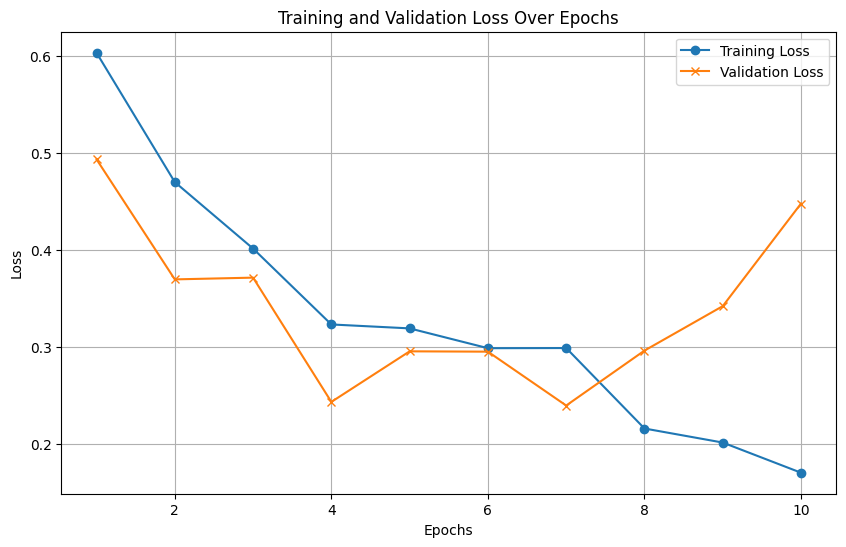

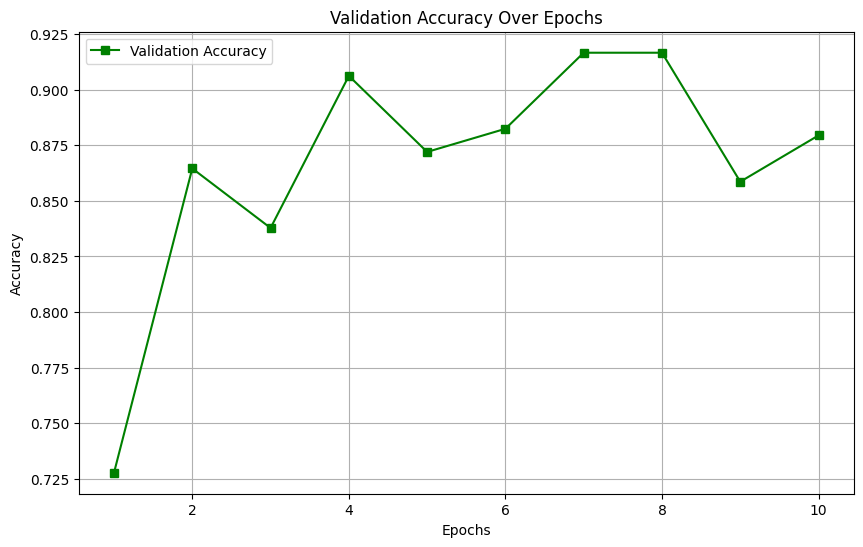

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", marker='o')
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy", marker='s', color='g')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

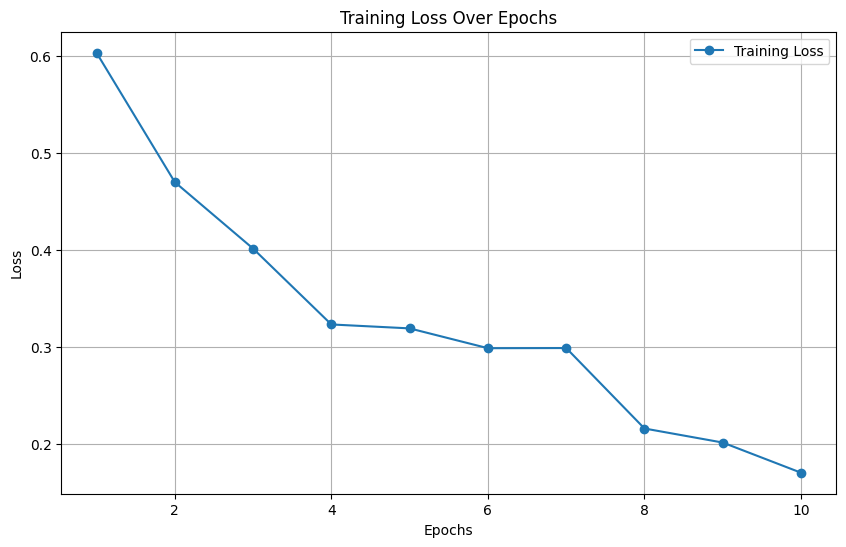

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
from sklearn.metrics import precision_recall_fscore_support

test_loss = 0.0
correct = 0.0
preds = []
labels_ = []

with torch.no_grad():
    model.eval()
    for i, (inputs, labels) in enumerate(dataloader_test):
        inputs = inputs.squeeze(1).to(device)
        inputs = inputs.repeat(1, 3, 1, 1) # For models that need 3 channels
        labels = labels.to(device).type(torch.float)

        outputs = model(inputs)
        preds.extend(outputs.round().cpu().numpy())
        labels_.extend(labels.round().cpu().numpy())

        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        correct += (outputs.round() == labels).float().sum().item()

acc = correct / len(dataloader_test.dataset)
avg_loss = test_loss / len(dataloader_test.dataset)
precision, recall, fscore, _ = precision_recall_fscore_support(labels_, preds, average="weighted", zero_division=np.nan)
print(f"Accuracy: {acc} | Precision: {precision} | Recall: {recall} | F1: {fscore} | Avg Loss: {avg_loss}")

Accuracy: 0.8653846153846154 | Precision: 0.8650452181540967 | Recall: 0.8653846153846154 | F1: 0.8566913771168344 | Avg Loss: 1.724358517390031


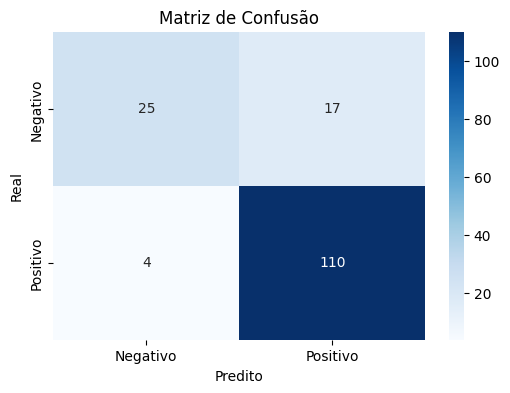

In [12]:
conf_matrix = confusion_matrix(labels_, preds)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()